# Absenteeism Clustering Analysis - Group 10
## Data Mining I (2025/26)
### "Why are they not here today?" - A Clustering-Based Exploration of Workplace Absence Patterns

---

**Objective:** Analyze employee absenteeism patterns using clustering techniques to develop targeted HR interventions.

**Notebook Structure:**
1. Data Exploration & Analysis
2. Data Preprocessing & Feature Engineering
3. Clustering Analysis & Validation
4. Cluster Profiling & Interpretation
5. HR Strategies & Knowledge in Action

# SETUP: Import Libraries and Configuration

to ensure you have all the required libraries installed, please run the following

pip install -r requirements.txt

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    silhouette_samples,
)
import warnings
warnings.filterwarnings('ignore')

# Configure visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

# Pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: f'{x:.2f}')

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


# PHASE 1: DATA EXPLORATION & ANALYSIS
Before clustering, we need to deeply understand the dataset characteristics, distributions, and relationships.

## 1.1 Load and Inspect Dataset

In [6]:
df = pd.read_csv('absenteeism_data.csv', sep=';')

print("="*80)
print("PHASE 1: DATA EXPLORATION")
print("="*80)
print(f"\nDataset Shape: {df.shape}")
print(f"Total Records: {df.shape[0]} employees")
print(f"Total Features: {df.shape[1]} variables")

print("\n" + "-"*80)
print("First 5 Records:")
print("-"*80)
display(df.head())

PHASE 1: DATA EXPLORATION

Dataset Shape: (800, 22)
Total Records: 800 employees
Total Features: 22 variables

--------------------------------------------------------------------------------
First 5 Records:
--------------------------------------------------------------------------------


,ID,Reason for absence,Month of absence,Day of the week,Seasons,Days since previous absence,Transportation expense,Distance from Residence to Work,Estimated commute time,Service time,Years until retirement,Date of Birth,Disciplinary failure,Education,Number of children,Social drinker,Social smoker,Number of pets,Weight,Height,Body mass index,Absenteeism time in hours
0,11,Unjustified absence,July,Tuesday,Summer,0.00,289,36,69,13,32,1992-08-15,No,1,2,Y,No,1,90,172,30,4
1,36,Unspecified,July,Tuesday,NaN,0.00,118,13,26,18,15,1975-09-02,Yes,1,1,Y,No,0,98,178,31,0
2,3,Medical consultation,July,Wednesday,Summer,0.00,179,51,108,18,27,1987-04-08,No,1,0,Yes,No,0,89,170,31,2
3,7,Diseases of the eye and adnexa,July,Thursday,NaN,0.00,279,5,5,14,26,1986-07-25,No,1,2,Yes,Yes,0,68,168,24,4
4,11,Medical consultation,July,Thursday,Summer,0.00,289,36,69,13,32,1992-08-15,No,1,2,Yes,No,1,90,172,30,2


In [7]:
print("\n" + "-"*80)
print("DATASET INFO & DATA TYPES")
print("-"*80)
print(df.info())

print("\n" + "-"*80)
print("MISSING VALUES ANALYSIS")
print("-"*80)
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing_data,
    'Percentage': missing_percent
}).sort_values('Missing_Count', ascending=False)
print(missing_df[missing_df['Missing_Count'] > 0])


--------------------------------------------------------------------------------
DATASET INFO & DATA TYPES
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               800 non-null    int64  
 1   Reason for absence               740 non-null    object 
 2   Month of absence                 737 non-null    object 
 3   Day of the week                  740 non-null    object 
 4   Seasons                          573 non-null    object 
 5   Days since previous absence      781 non-null    float64
 6   Transportation expense           800 non-null    int64  
 7   Distance from Residence to Work  800 non-null    int64  
 8   Estimated commute time           800 non-null    int64  
 9   Service time       

## 1.2 Statistical Summary

In [8]:
print("\n" + "-"*80)
print("NUMERICAL FEATURES - DESCRIPTIVE STATISTICS")
print("-"*80)
stats_summary = df.describe()
display(stats_summary)

print("\n" + "-"*80)
print("ADDITIONAL STATISTICS (Skewness, Kurtosis, IQR)")
print("-"*80)
numerical_df = df.select_dtypes(include=[np.number])
additional_stats = pd.DataFrame({
    'Skewness': numerical_df.skew(),
    'Kurtosis': numerical_df.kurtosis(),
    'IQR': numerical_df.quantile(0.75) - numerical_df.quantile(0.25)
})
display(additional_stats)


--------------------------------------------------------------------------------
NUMERICAL FEATURES - DESCRIPTIVE STATISTICS
--------------------------------------------------------------------------------


,ID,Days since previous absence,Transportation expense,Distance from Residence to Work,Estimated commute time,Years until retirement,Education,Number of children,Number of pets,Height,Body mass index,Absenteeism time in hours
count,800.00,781.00,800.00,800.00,800.00,800.00,800.00,800.00,800.00,800.00,800.00,800.00
mean,17.98,0.00,221.93,29.80,59.35,26.74,1.29,1.04,0.74,172.09,26.64,7.09
std,10.95,0.00,66.78,14.88,31.30,9.27,0.67,1.12,1.32,6.06,4.27,13.95
min,1.00,0.00,118.00,5.00,5.00,-1.00,1.00,0.00,0.00,163.00,19.00,0.00
25%,10.00,0.00,179.00,16.00,31.00,25.00,1.00,0.00,0.00,169.00,24.00,2.00
50%,18.00,0.00,225.00,26.00,52.00,28.00,1.00,1.00,0.00,170.00,25.00,3.00
75%,28.00,0.00,260.00,50.00,94.00,33.00,1.00,2.00,1.00,172.00,31.00,8.00
max,36.00,0.00,388.00,52.00,114.00,38.00,4.00,4.00,8.00,196.00,38.00,120.00



--------------------------------------------------------------------------------
ADDITIONAL STATISTICS (Skewness, Kurtosis, IQR)
--------------------------------------------------------------------------------


,Skewness,Kurtosis,IQR
ID,0.02,-1.23,18.00
Days since previous absence,0.00,0.00,0.00
Transportation expense,0.39,-0.32,81.00
Distance from Residence to Work,0.30,-1.28,34.00
Estimated commute time,0.47,-1.13,63.00
Years until retirement,-1.49,2.28,8.00
Education,2.13,3.07,0.00
Number of children,1.07,0.66,2.00
Number of pets,2.76,9.82,1.00
Height,2.58,7.37,3.00


## 1.3 Target Variable Visualization

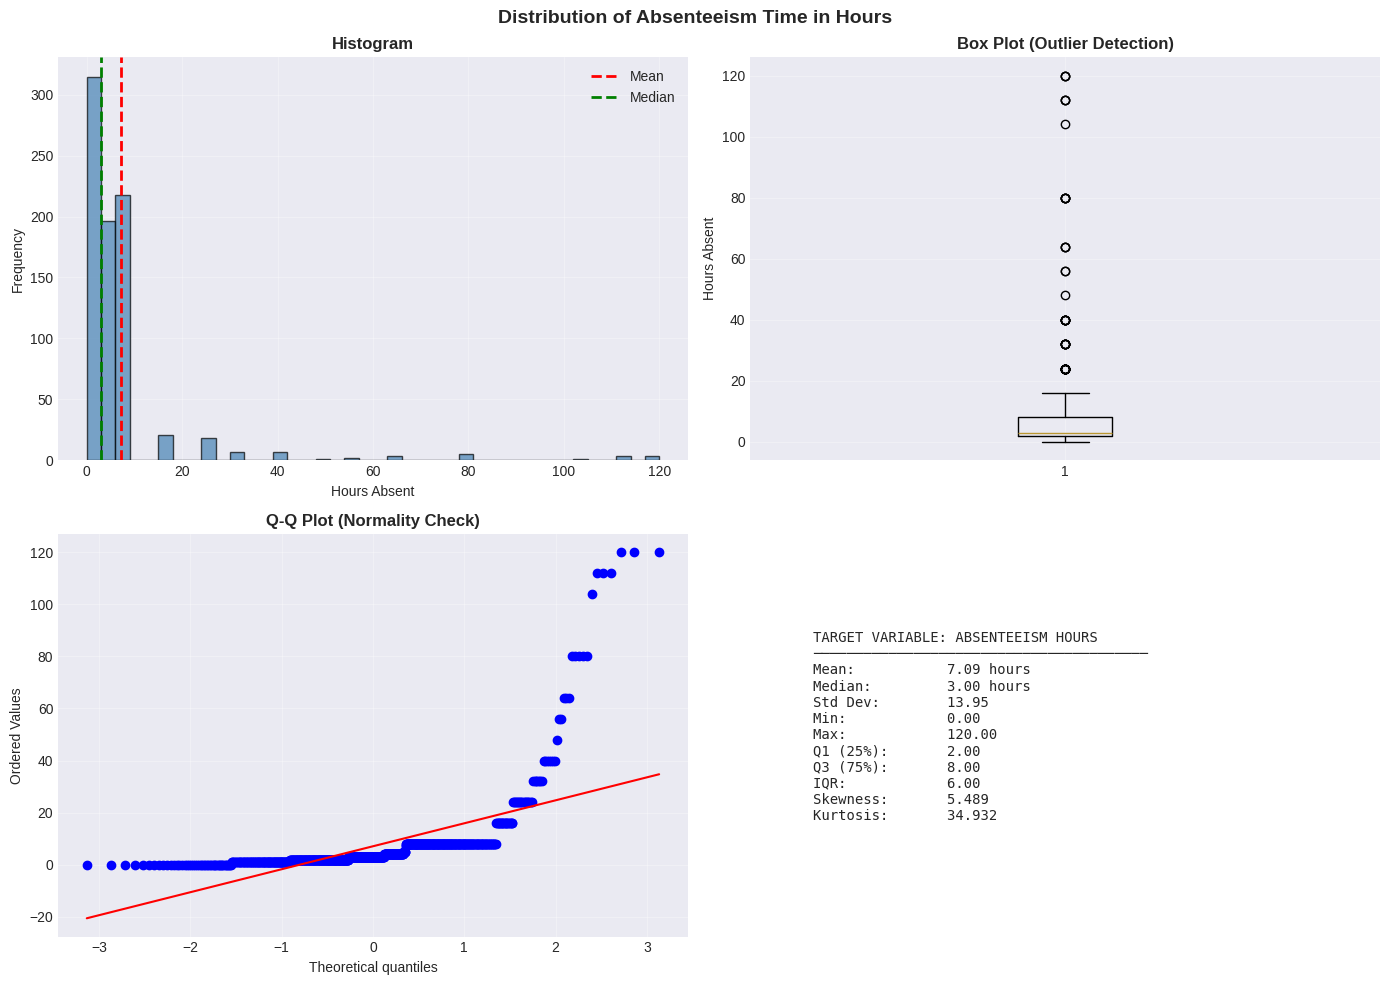


✓ Saved: 01_target_distribution.png


In [9]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Distribution of Absenteeism Time in Hours', fontsize=14, fontweight='bold')

# Histogram
axes[0, 0].hist(df['Absenteeism time in hours'], bins=40, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].set_title('Histogram', fontweight='bold')
axes[0, 0].set_xlabel('Hours Absent')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df['Absenteeism time in hours'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[0, 0].axvline(df['Absenteeism time in hours'].median(), color='green', linestyle='--', linewidth=2, label='Median')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Box plot
axes[0, 1].boxplot(df['Absenteeism time in hours'], vert=True)
axes[0, 1].set_title('Box Plot (Outlier Detection)', fontweight='bold')
axes[0, 1].set_ylabel('Hours Absent')
axes[0, 1].grid(True, alpha=0.3)

# Q-Q Plot
stats.probplot(df['Absenteeism time in hours'], dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Normality Check)', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Statistics box
axes[1, 1].axis('off')
stats_text = f"""TARGET VARIABLE: ABSENTEEISM HOURS
{'─'*40}
Mean:           {df['Absenteeism time in hours'].mean():.2f} hours
Median:         {df['Absenteeism time in hours'].median():.2f} hours
Std Dev:        {df['Absenteeism time in hours'].std():.2f}
Min:            {df['Absenteeism time in hours'].min():.2f}
Max:            {df['Absenteeism time in hours'].max():.2f}
Q1 (25%):       {df['Absenteeism time in hours'].quantile(0.25):.2f}
Q3 (75%):       {df['Absenteeism time in hours'].quantile(0.75):.2f}
IQR:            {df['Absenteeism time in hours'].quantile(0.75) - df['Absenteeism time in hours'].quantile(0.25):.2f}
Skewness:       {df['Absenteeism time in hours'].skew():.3f}
Kurtosis:       {df['Absenteeism time in hours'].kurtosis():.3f}
"""
axes[1, 1].text(0.1, 0.5, stats_text, fontsize=10, family='monospace', verticalalignment='center')

plt.tight_layout()
plt.savefig('01_target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n✓ Saved: 01_target_distribution.png")

## 1.4 Correlation Analysis


--------------------------------------------------------------------------------
CORRELATION ANALYSIS
--------------------------------------------------------------------------------

Top 10 Correlations with Absenteeism Hours:
Absenteeism time in hours          1.00
Height                             0.16
Number of children                 0.11
Transportation expense             0.02
ID                                -0.01
Number of pets                    -0.03
Body mass index                   -0.05
Education                         -0.05
Years until retirement            -0.06
Distance from Residence to Work   -0.11
Name: Absenteeism time in hours, dtype: float64


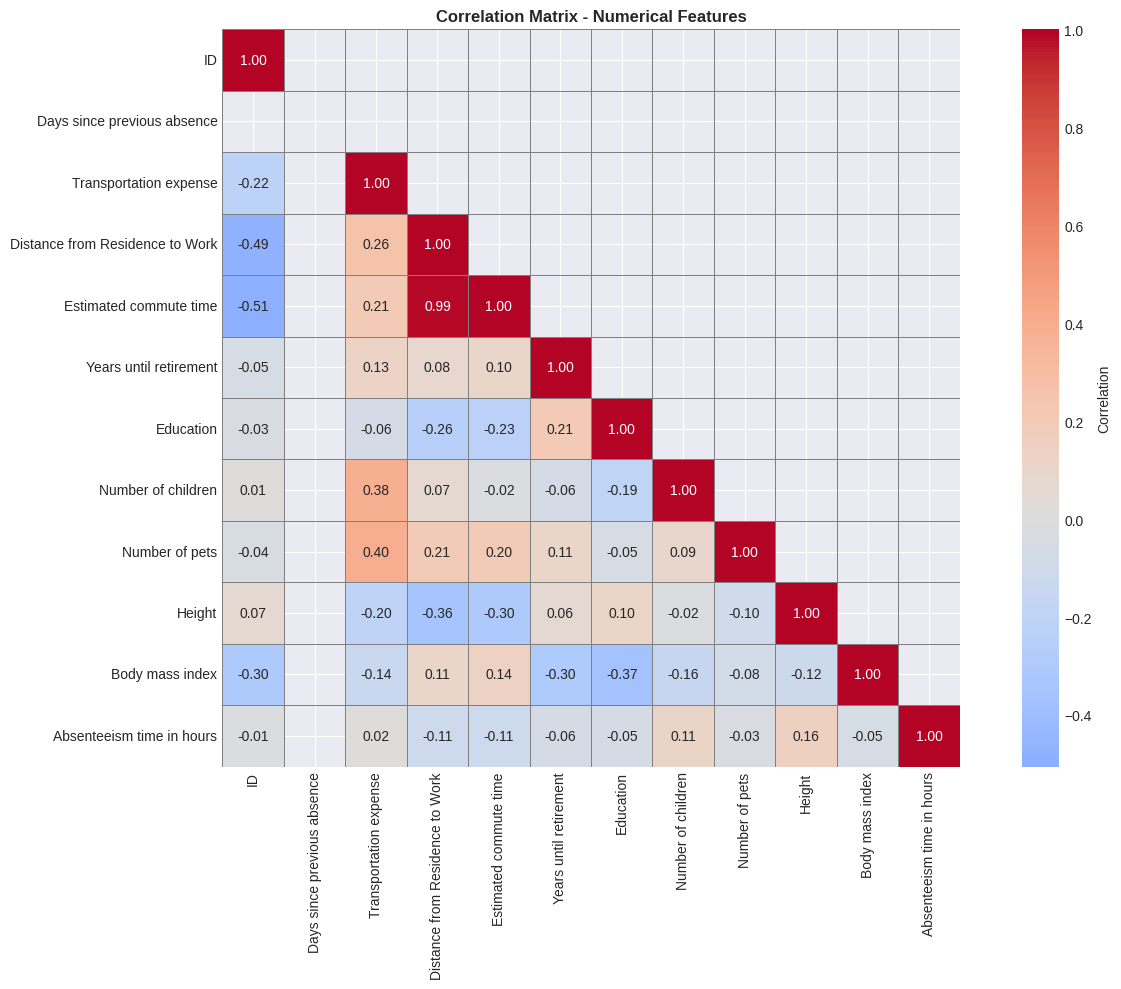


✓ Saved: 02_correlation_matrix.png


In [10]:
print("\n" + "-"*80)
print("CORRELATION ANALYSIS")
print("-"*80)

numerical_df = df.select_dtypes(include=[np.number])
corr_matrix = numerical_df.corr()

# Top correlations with target variable
target_corr = corr_matrix['Absenteeism time in hours'].sort_values(ascending=False)
print("\nTop 10 Correlations with Absenteeism Hours:")
print(target_corr.head(10))

# Visualize correlation matrix
fig, ax = plt.subplots(figsize=(14, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            mask=mask, square=True, ax=ax, cbar_kws={'label': 'Correlation'},
            linewidths=0.5, linecolor='gray')
ax.set_title('Correlation Matrix - Numerical Features', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('02_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n✓ Saved: 02_correlation_matrix.png")

## 1.5 Categorical Features Analysis


--------------------------------------------------------------------------------
CATEGORICAL FEATURES ANALYSIS
--------------------------------------------------------------------------------

Reason for absence:
  Unique Values: 28
  Top 5 Values:
Reason for absence
Medical consultation                                            149
Dental consultation                                             112
Physiotherapy                                                    69
Diseases of the musculoskeletal system and connective tissue     55
Unspecified                                                      43
Name: count, dtype: int64

Month of absence:
  Unique Values: 12
  Top 5 Values:
Month of absence
March       87
February    72
October     71
July        67
May         64
Name: count, dtype: int64

Day of the week:
  Unique Values: 6
  Top 5 Values:
Day of the week
Monday       159
Wednesday    155
Tuesday      153
Friday       142
Thursday     125
Name: count, dtype: int64

Seasons:
  

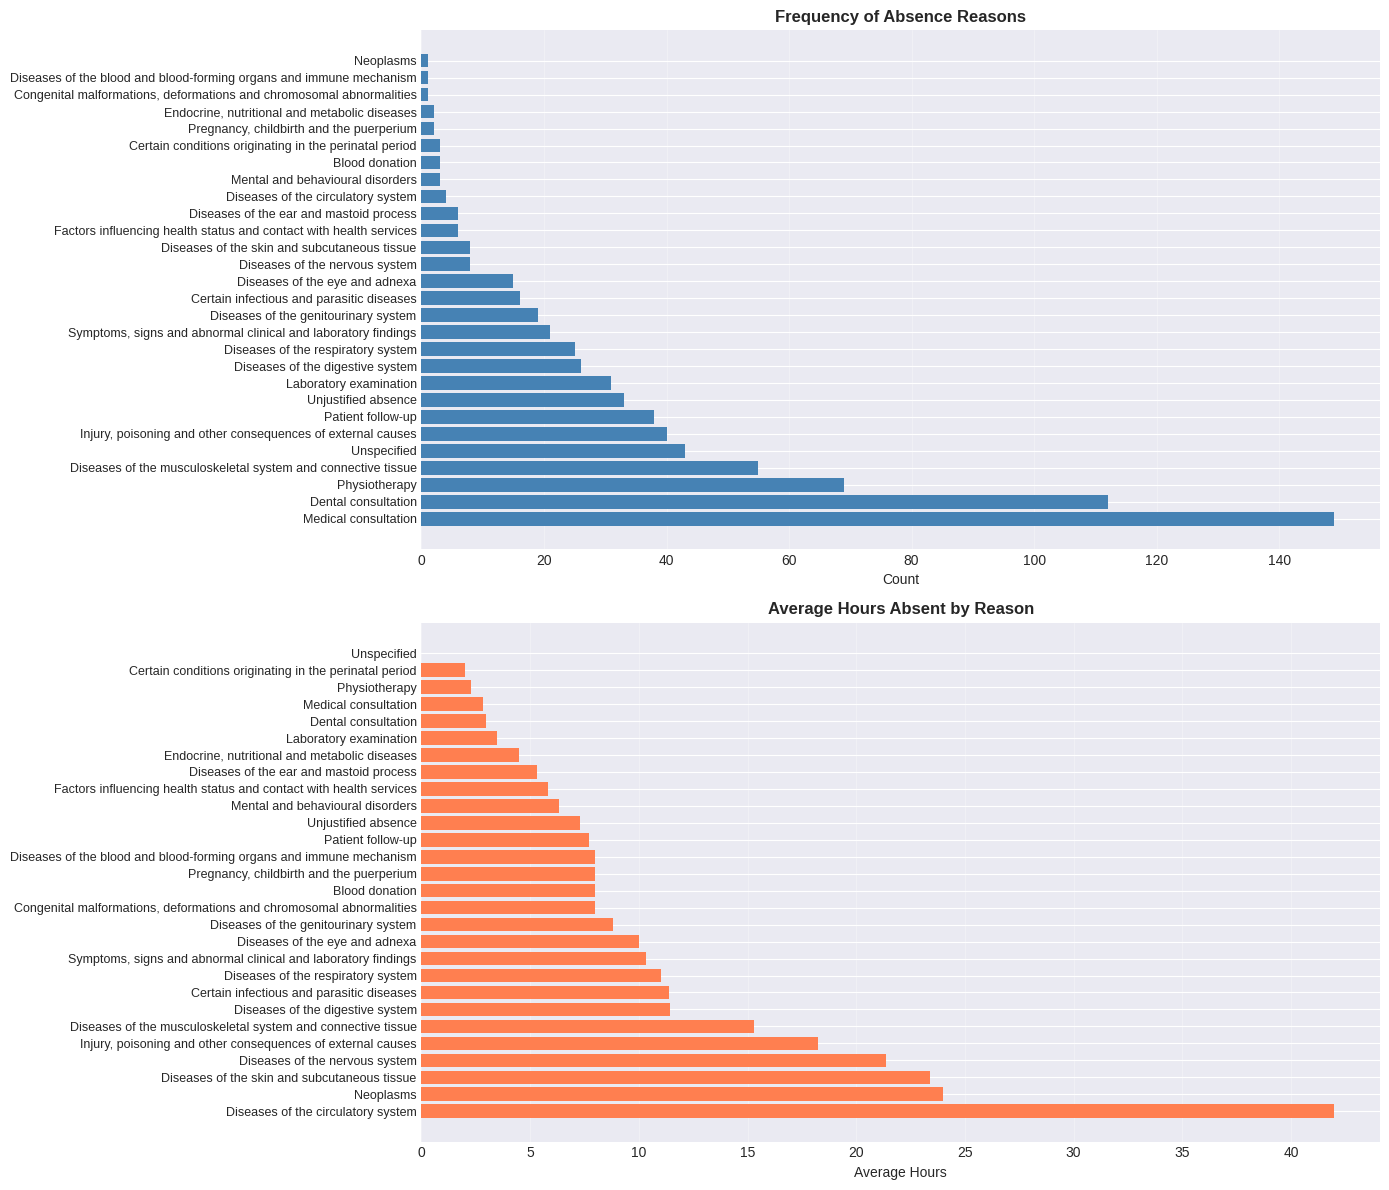


✓ Saved: 03_categorical_analysis.png


In [11]:
print("\n" + "-"*80)
print("CATEGORICAL FEATURES ANALYSIS")
print("-"*80)

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

for col in categorical_cols:
    print(f"\n{col}:")
    print(f"  Unique Values: {df[col].nunique()}")
    print(f"  Top 5 Values:")
    print(df[col].value_counts().head(5))

# Visualize reason for absence
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

reason_counts = df['Reason for absence'].value_counts()
reason_absence_hours = df.groupby('Reason for absence')['Absenteeism time in hours'].mean().sort_values(ascending=False)

axes[0].barh(range(len(reason_counts)), reason_counts.values, color='steelblue')
axes[0].set_yticks(range(len(reason_counts)))
axes[0].set_yticklabels(reason_counts.index, fontsize=9)
axes[0].set_title('Frequency of Absence Reasons', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Count')
axes[0].grid(True, alpha=0.3, axis='x')

axes[1].barh(range(len(reason_absence_hours)), reason_absence_hours.values, color='coral')
axes[1].set_yticks(range(len(reason_absence_hours)))
axes[1].set_yticklabels(reason_absence_hours.index, fontsize=9)
axes[1].set_title('Average Hours Absent by Reason', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Average Hours')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('03_categorical_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n✓ Saved: 03_categorical_analysis.png")

# PHASE 2: DATA PREPROCESSING & FEATURE ENGINEERING

## 2.1 Feature Engineering

In [12]:
print("\n" + "="*80)
print("PHASE 2: DATA PREPROCESSING")
print("="*80)

df_prep = df.copy()

print("\n[1] Feature Engineering")
print("-"*80)

# Calculate age from Date of Birth
df_prep['Date of Birth'] = pd.to_datetime(df_prep['Date of Birth'])
reference_date = pd.Timestamp('2024-01-01')
df_prep['Age'] = (reference_date - df_prep['Date of Birth']).dt.days / 365.25
df_prep['Age'] = df_prep['Age'].astype(int)

print(f"✓ Age Feature Created:")
print(f"  Mean: {df_prep['Age'].mean():.1f} years")
print(f"  Range: [{df_prep['Age'].min()}, {df_prep['Age'].max()}] years")

# Create commute burden index
df_prep['Commute_Burden_Index'] = (
    (df_prep['Transportation expense'] / df_prep['Transportation expense'].max()) * 0.3 +
    (df_prep['Distance from Residence to Work'] / df_prep['Distance from Residence to Work'].max()) * 0.35 +
    (df_prep['Estimated commute time'] / df_prep['Estimated commute time'].max()) * 0.35
)

print(f"\n✓ Commute Burden Index Created:")
print(f"  Mean: {df_prep['Commute_Burden_Index'].mean():.3f}")
print(f"  Range: [{df_prep['Commute_Burden_Index'].min():.3f}, {df_prep['Commute_Burden_Index'].max():.3f}]")


PHASE 2: DATA PREPROCESSING

[1] Feature Engineering
--------------------------------------------------------------------------------
✓ Age Feature Created:
  Mean: 34.4 years
  Range: [25, 56] years

✓ Commute Burden Index Created:
  Mean: 0.554
  Range: [0.226, 0.979]


## 2.2 Missing Value Handling

In [13]:
print("\n[2] Missing Value Handling Strategy")
print("-"*80)

# Identify columns with missing values
missing_cols = df_prep.columns[df_prep.isnull().any()].tolist()

if missing_cols:
    for col in missing_cols:
        missing_count = df_prep[col].isnull().sum()
        if col == 'Seasons':
            season_mode = df_prep['Seasons'].mode()[0]
            df_prep['Seasons'].fillna(season_mode, inplace=True)
            print(f"✓ {col}: Filled {missing_count} missing values with mode '{season_mode}'")
else:
    print("✓ No additional missing values detected after feature engineering")

print(f"\nPost-imputation missing values: {df_prep.isnull().sum().sum()}")


[2] Missing Value Handling Strategy
--------------------------------------------------------------------------------
✓ Seasons: Filled 227 missing values with mode 'Spring'

Post-imputation missing values: 202


## 2.3 Outlier Detection

In [14]:
print("\n[3] Outlier Detection (IQR Method)")
print("-"*80)

numerical_cols = df_prep.select_dtypes(include=[np.number]).columns.tolist()
outlier_summary = {}

for col in numerical_cols:
    Q1 = df_prep[col].quantile(0.25)
    Q3 = df_prep[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df_prep[(df_prep[col] < lower_bound) | (df_prep[col] > upper_bound)]
    outlier_count = len(outliers)
    
    if outlier_count > 0:
        outlier_summary[col] = {
            'count': outlier_count,
            'percentage': (outlier_count / len(df_prep)) * 100,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        }

if outlier_summary:
    print("Outliers Detected (Retaining for informative value):")
    outlier_df = pd.DataFrame([
        {'Feature': col, 'Count': info['count'], 'Percentage': f"{info['percentage']:.1f}%"}
        for col, info in outlier_summary.items()
    ])
    display(outlier_df)
else:
    print("No significant outliers detected")


[3] Outlier Detection (IQR Method)
--------------------------------------------------------------------------------
Outliers Detected (Retaining for informative value):


,Feature,Count,Percentage
0,Transportation expense,3,0.4%
1,Years until retirement,55,6.9%
2,Education,138,17.2%
3,Number of pets,50,6.2%
4,Height,127,15.9%
5,Absenteeism time in hours,50,6.2%
6,Age,10,1.2%


## 2.4 Categorical Variable Encoding

In [15]:
print("\n[4] Categorical Variable Encoding")
print("-"*80)

# Fix inconsistent binary values
df_prep['Social drinker'] = df_prep['Social drinker'].map({'Y': 1, 'Yes': 1, 'N': 0, 'No': 0})
df_prep['Social smoker'] = df_prep['Social smoker'].map({'Yes': 1, 'No': 0})
df_prep['Disciplinary failure'] = df_prep['Disciplinary failure'].map({'Yes': 1, 'No': 0})
print("✓ Binary variables standardized (0/1 encoding)")

# One-hot encode Reason for absence
reason_dummies = pd.get_dummies(df_prep['Reason for absence'], prefix='Reason', drop_first=True)
df_prep = pd.concat([df_prep, reason_dummies], axis=1)
print(f"✓ Reason for absence: {len(reason_dummies.columns)} binary features created")

# Encode seasons
season_dummies = pd.get_dummies(df_prep['Seasons'], prefix='Season', drop_first=True)
df_prep = pd.concat([df_prep, season_dummies], axis=1)
print(f"✓ Seasons: {len(season_dummies.columns)} features created")

# Encode day of week
day_dummies = pd.get_dummies(df_prep['Day of the week'], prefix='Day', drop_first=True)
df_prep = pd.concat([df_prep, day_dummies], axis=1)
print(f"✓ Day of week: {len(day_dummies.columns)} features created")


[4] Categorical Variable Encoding
--------------------------------------------------------------------------------
✓ Binary variables standardized (0/1 encoding)
✓ Reason for absence: 27 binary features created
✓ Seasons: 3 features created
✓ Day of week: 5 features created


## 2.5 Feature Selection for Clustering

In [16]:
print("\n[5] Feature Selection for Clustering")
print("-"*80)

# Drop non-clustering features
drop_cols = ['ID', 'Reason for absence', 'Month of absence', 'Day of the week',
             'Seasons', 'Date of Birth', 'Absenteeism time in hours']

df_clustering = df_prep.drop(columns=drop_cols, errors='ignore')

print(f"✓ Removed {len(drop_cols)} non-clustering features")
print(f"✓ Final feature set: {df_clustering.shape[1]} features")
print(f"\nFeatures for clustering:")
print(df_clustering.columns.tolist())


[5] Feature Selection for Clustering
--------------------------------------------------------------------------------
✓ Removed 7 non-clustering features
✓ Final feature set: 52 features

Features for clustering:
['Days since previous absence', 'Transportation expense', 'Distance from Residence to Work', 'Estimated commute time', 'Service time', 'Years until retirement', 'Disciplinary failure', 'Education', 'Number of children', 'Social drinker', 'Social smoker', 'Number of pets', 'Weight', 'Height', 'Body mass index', 'Age', 'Commute_Burden_Index', 'Reason_Certain conditions originating in the perinatal period', 'Reason_Certain infectious and parasitic diseases', 'Reason_Congenital malformations, deformations and chromosomal abnormalities', 'Reason_Dental consultation', 'Reason_Diseases of the blood and blood-forming organs and immune mechanism', 'Reason_Diseases of the circulatory system', 'Reason_Diseases of the digestive system', 'Reason_Diseases of the ear and mastoid process', '

## 2.6 Feature Scaling

In [18]:
print("\n[6] Feature Scaling (Standardization)")
print("-" * 80)

# 1) Replace '-' with NaN
df_clean = df_clustering.replace('-', np.nan)

# 2) Drop rows with any NaN in clustering features
df_clean = df_clean.dropna()

# 3) Keep only numeric columns for scaling
df_num = df_clean.select_dtypes(include=['number'])

# 4) Standardize numeric features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_num)
df_scaled = pd.DataFrame(df_scaled, columns=df_num.columns)

print(f"✓ Applied StandardScaler (Z-score normalization)")
print(f"  Mean after scaling: {df_scaled.mean().mean():.6f}")
print(f"  Std after scaling: {df_scaled.std().mean():.3f}")

print(f"\nScaled Data Shape: {df_scaled.shape}")
print(f"\nFirst 5 rows of scaled data:")
display(df_scaled.head())



[6] Feature Scaling (Standardization)
--------------------------------------------------------------------------------
✓ Applied StandardScaler (Z-score normalization)
  Mean after scaling: -0.000000
  Std after scaling: 0.934

Scaled Data Shape: (678, 15)

First 5 rows of scaled data:


,Days since previous absence,Transportation expense,Distance from Residence to Work,Estimated commute time,Years until retirement,Disciplinary failure,Education,Number of children,Social drinker,Social smoker,Number of pets,Height,Body mass index,Age,Commute_Burden_Index
0,0.00,1.00,0.41,0.30,0.56,-0.24,-0.44,0.84,0.87,-0.26,0.18,-0.00,0.79,-0.52,0.57
1,0.00,-1.59,-1.14,-1.07,-1.29,4.22,-0.44,-0.05,0.87,-0.26,-0.56,1.00,1.02,2.07,-1.40
2,0.00,-0.67,1.42,1.55,0.01,-0.24,-0.44,-0.94,0.87,-0.26,-0.56,-0.34,1.02,0.24,1.20
3,0.00,0.85,-1.68,-1.74,-0.09,-0.24,-0.44,0.84,0.87,3.84,-0.56,-0.67,-0.61,0.40,-1.37
4,0.00,1.00,0.41,0.30,0.56,-0.24,-0.44,0.84,0.87,-0.26,0.18,-0.00,0.79,-0.52,0.57


## 2.7 Preprocessing Impact Visualization

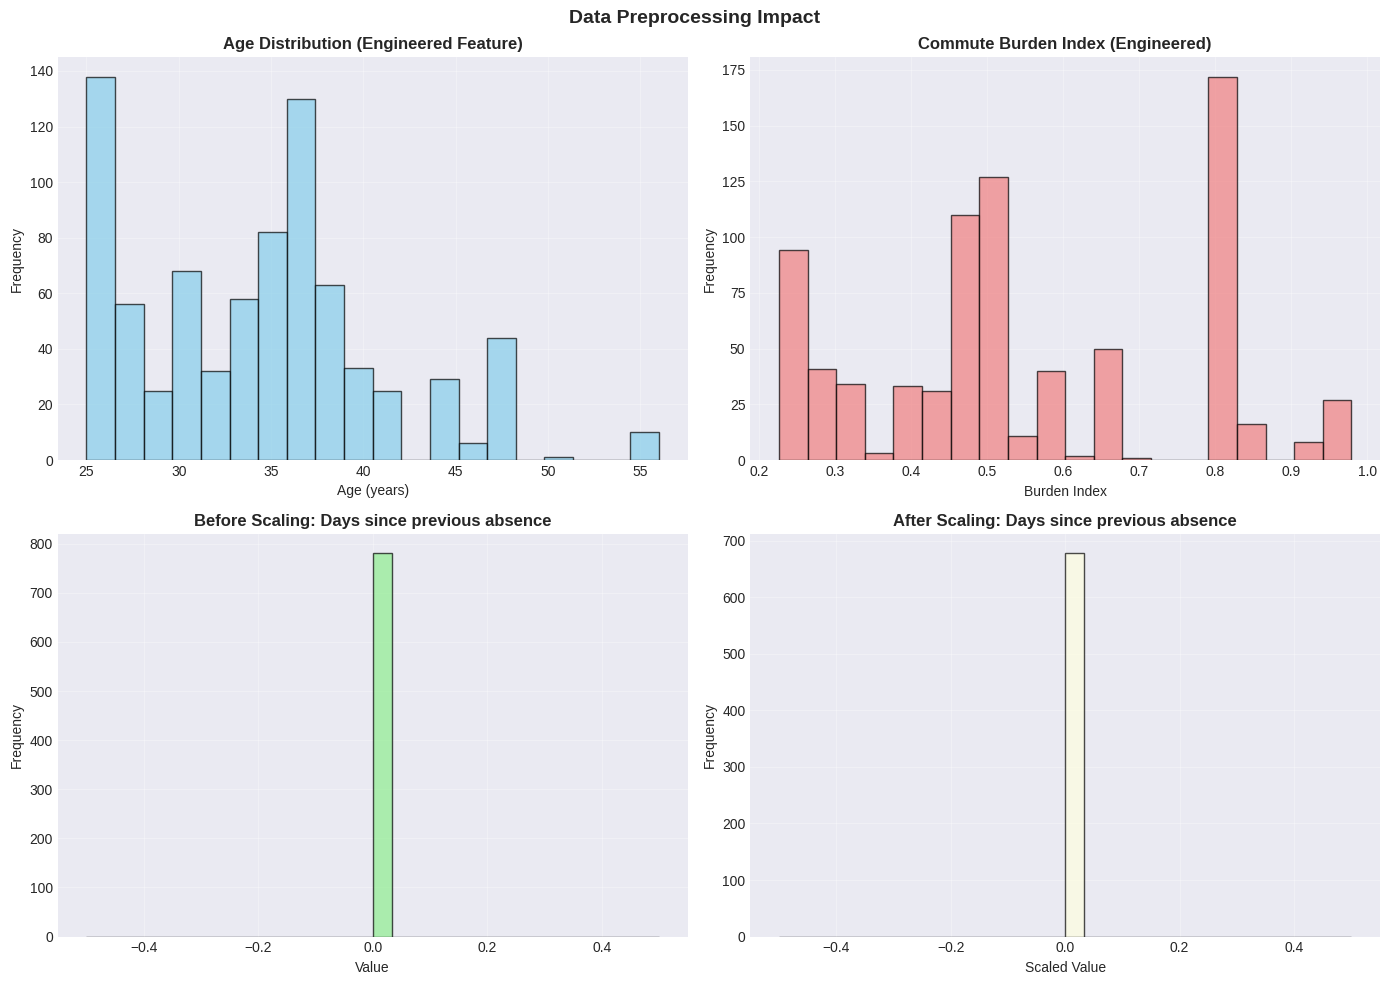

✓ Saved: 04_preprocessing_impact.png


In [19]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Data Preprocessing Impact', fontsize=14, fontweight='bold')

# Age distribution
axes[0, 0].hist(df_prep['Age'], bins=20, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 0].set_title('Age Distribution (Engineered Feature)', fontweight='bold')
axes[0, 0].set_xlabel('Age (years)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

# Commute Burden Index
axes[0, 1].hist(df_prep['Commute_Burden_Index'], bins=20, edgecolor='black', alpha=0.7, color='lightcoral')
axes[0, 1].set_title('Commute Burden Index (Engineered)', fontweight='bold')
axes[0, 1].set_xlabel('Burden Index')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# Before scaling
sample_col_idx = 0
sample_col = df_clustering.columns[sample_col_idx]
axes[1, 0].hist(df_clustering[sample_col], bins=30, edgecolor='black', alpha=0.7, color='lightgreen')
axes[1, 0].set_title(f'Before Scaling: {sample_col}', fontweight='bold')
axes[1, 0].set_xlabel('Value')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True, alpha=0.3)

# After scaling
axes[1, 1].hist(df_scaled.iloc[:, sample_col_idx], bins=30, edgecolor='black', alpha=0.7, color='lightyellow')
axes[1, 1].set_title(f'After Scaling: {sample_col}', fontweight='bold')
axes[1, 1].set_xlabel('Scaled Value')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('04_preprocessing_impact.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: 04_preprocessing_impact.png")

# PHASE 3: CLUSTERING ANALYSIS

## 3.1 Determine Optimal Number of Clusters

In [23]:
print("\n" + "="*80)
print("PHASE 3: CLUSTERING - ALGORITHM SELECTION & EVALUATION")
print("="*80)

print("\n[1] Determining Optimal Number of Clusters (K-Means)")
print("-"*80)

inertias = []
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_scaled, labels))
    davies_bouldin_scores.append(davies_bouldin_score(df_scaled, labels))
    calinski_harabasz_scores.append(calinski_harabasz_score(df_scaled, labels))
    
    print(f"k={k}: Silhouette={silhouette_scores[-1]:.4f}, DB={davies_bouldin_scores[-1]:.4f}, CH={calinski_harabasz_scores[-1]:.2f}")


PHASE 3: CLUSTERING - ALGORITHM SELECTION & EVALUATION

[1] Determining Optimal Number of Clusters (K-Means)
--------------------------------------------------------------------------------
k=2: Silhouette=0.2328, DB=1.7602, CH=179.08
k=3: Silhouette=0.2613, DB=1.8049, CH=155.62
k=4: Silhouette=0.2800, DB=1.6168, CH=136.88
k=5: Silhouette=0.3214, DB=1.5332, CH=138.55
k=6: Silhouette=0.3591, DB=1.3109, CH=141.56
k=7: Silhouette=0.4168, DB=1.1301, CH=149.27
k=8: Silhouette=0.4519, DB=1.1950, CH=159.78
k=9: Silhouette=0.4985, DB=1.0253, CH=167.68
k=10: Silhouette=0.5229, DB=0.9627, CH=176.90


## 3.2 Visualization of Validation Metrics

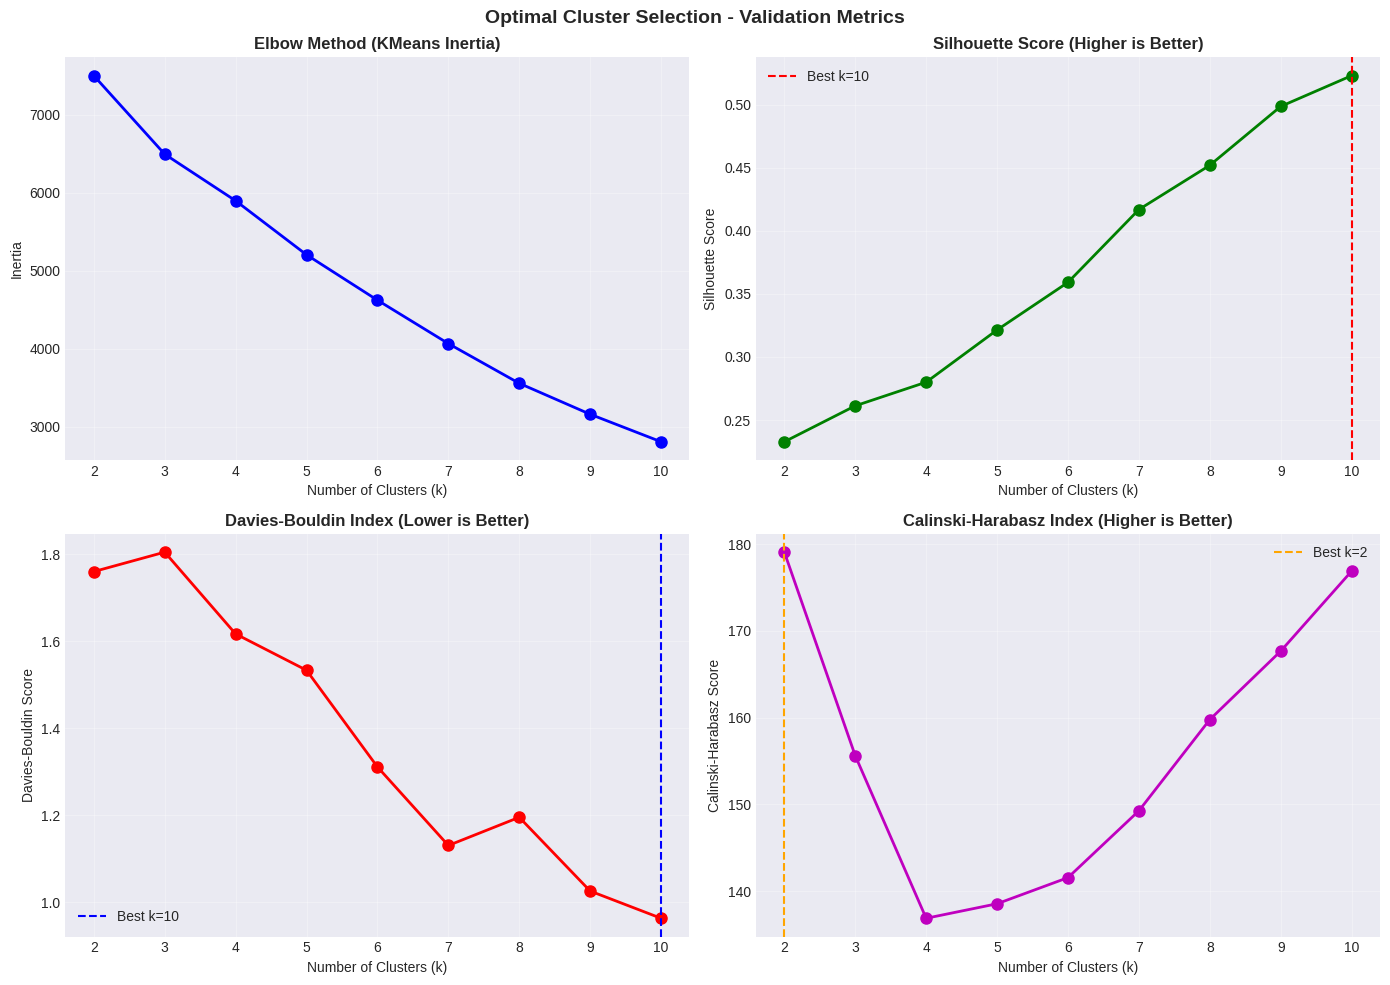

✓ Saved: 05_optimal_clusters_validation.png

Optimal k Recommendations:
  Silhouette Score: k=10
  Davies-Bouldin Index: k=10
  Calinski-Harabasz Index: k=2


In [24]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Optimal Cluster Selection - Validation Metrics', fontsize=14, fontweight='bold')

# Elbow Method
axes[0, 0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_title('Elbow Method (KMeans Inertia)', fontweight='bold')
axes[0, 0].set_xlabel('Number of Clusters (k)')
axes[0, 0].set_ylabel('Inertia')
axes[0, 0].grid(True, alpha=0.3)

# Silhouette Score
axes[0, 1].plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
best_k_silhouette = list(K_range)[np.argmax(silhouette_scores)]
axes[0, 1].axvline(x=best_k_silhouette, color='red', linestyle='--', label=f'Best k={best_k_silhouette}')
axes[0, 1].set_title('Silhouette Score (Higher is Better)', fontweight='bold')
axes[0, 1].set_xlabel('Number of Clusters (k)')
axes[0, 1].set_ylabel('Silhouette Score')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Davies-Bouldin Index
axes[1, 0].plot(K_range, davies_bouldin_scores, 'ro-', linewidth=2, markersize=8)
best_k_db = list(K_range)[np.argmin(davies_bouldin_scores)]
axes[1, 0].axvline(x=best_k_db, color='blue', linestyle='--', label=f'Best k={best_k_db}')
axes[1, 0].set_title('Davies-Bouldin Index (Lower is Better)', fontweight='bold')
axes[1, 0].set_xlabel('Number of Clusters (k)')
axes[1, 0].set_ylabel('Davies-Bouldin Score')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Calinski-Harabasz Index
axes[1, 1].plot(K_range, calinski_harabasz_scores, 'mo-', linewidth=2, markersize=8)
best_k_ch = list(K_range)[np.argmax(calinski_harabasz_scores)]
axes[1, 1].axvline(x=best_k_ch, color='orange', linestyle='--', label=f'Best k={best_k_ch}')
axes[1, 1].set_title('Calinski-Harabasz Index (Higher is Better)', fontweight='bold')
axes[1, 1].set_xlabel('Number of Clusters (k)')
axes[1, 1].set_ylabel('Calinski-Harabasz Score')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('05_optimal_clusters_validation.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: 05_optimal_clusters_validation.png")

print(f"\nOptimal k Recommendations:")
print(f"  Silhouette Score: k={best_k_silhouette}")
print(f"  Davies-Bouldin Index: k={best_k_db}")
print(f"  Calinski-Harabasz Index: k={best_k_ch}")

## 3.3 Algorithm Comparison

In [25]:
optimal_k = 3  # Choose k=3 based on consensus

print("\n[2] Comparing Multiple Clustering Algorithms")
print("-"*80)
print(f"\nUsing k={optimal_k} clusters\n")

results = {}

# KMeans
print("Testing KMeans Clustering...")
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(df_scaled)
kmeans_silhouette = silhouette_score(df_scaled, kmeans_labels)
kmeans_db = davies_bouldin_score(df_scaled, kmeans_labels)
kmeans_ch = calinski_harabasz_score(df_scaled, kmeans_labels)
print(f"  ✓ Silhouette: {kmeans_silhouette:.4f} | DB: {kmeans_db:.4f} | CH: {kmeans_ch:.2f}")

results['KMeans'] = {
    'model': kmeans,
    'labels': kmeans_labels,
    'silhouette': kmeans_silhouette,
    'davies_bouldin': kmeans_db,
    'calinski_harabasz': kmeans_ch
}

# Hierarchical Clustering
print("\nTesting Hierarchical Clustering...")
hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
hier_labels = hierarchical.fit_predict(df_scaled)
hier_silhouette = silhouette_score(df_scaled, hier_labels)
hier_db = davies_bouldin_score(df_scaled, hier_labels)
hier_ch = calinski_harabasz_score(df_scaled, hier_labels)
print(f"  ✓ Silhouette: {hier_silhouette:.4f} | DB: {hier_db:.4f} | CH: {hier_ch:.2f}")

results['Hierarchical'] = {
    'model': hierarchical,
    'labels': hier_labels,
    'silhouette': hier_silhouette,
    'davies_bouldin': hier_db,
    'calinski_harabasz': hier_ch
}

# DBSCAN
print("\nTesting DBSCAN Clustering...")
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(df_scaled)
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

if n_clusters_dbscan > 1 and n_noise < len(df_scaled) * 0.5:
    dbscan_silhouette = silhouette_score(df_scaled[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1])
    dbscan_db = davies_bouldin_score(df_scaled[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1])
    dbscan_ch = calinski_harabasz_score(df_scaled[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1])
    print(f"  ✓ Found {n_clusters_dbscan} clusters, {n_noise} noise points")
    print(f"  ✓ Silhouette: {dbscan_silhouette:.4f} | DB: {dbscan_db:.4f} | CH: {dbscan_ch:.2f}")
else:
    print(f"  ✗ Could not find optimal clusters")
    dbscan_silhouette = dbscan_db = dbscan_ch = None

results['DBSCAN'] = {
    'model': dbscan,
    'labels': dbscan_labels,
    'silhouette': dbscan_silhouette,
    'davies_bouldin': dbscan_db,
    'calinski_harabasz': dbscan_ch
}

# Gaussian Mixture Model
print("\nTesting Gaussian Mixture Model...")
gmm = GaussianMixture(n_components=optimal_k, random_state=42)
gmm_labels = gmm.fit_predict(df_scaled)
gmm_silhouette = silhouette_score(df_scaled, gmm_labels)
gmm_db = davies_bouldin_score(df_scaled, gmm_labels)
gmm_ch = calinski_harabasz_score(df_scaled, gmm_labels)
print(f"  ✓ Silhouette: {gmm_silhouette:.4f} | DB: {gmm_db:.4f} | CH: {gmm_ch:.2f}")

results['GMM'] = {
    'model': gmm,
    'labels': gmm_labels,
    'silhouette': gmm_silhouette,
    'davies_bouldin': gmm_db,
    'calinski_harabasz': gmm_ch
}


[2] Comparing Multiple Clustering Algorithms
--------------------------------------------------------------------------------

Using k=3 clusters

Testing KMeans Clustering...
  ✓ Silhouette: 0.2613 | DB: 1.8049 | CH: 155.62

Testing Hierarchical Clustering...
  ✓ Silhouette: 0.2364 | DB: 1.8846 | CH: 130.33

Testing DBSCAN Clustering...
  ✓ Found 26 clusters, 78 noise points
  ✓ Silhouette: 1.0000 | DB: 0.0000 | CH: 76900306576156360078633568567296.00

Testing Gaussian Mixture Model...
  ✓ Silhouette: 0.2586 | DB: 1.6237 | CH: 126.28


## 3.4 Algorithm Comparison Table

In [26]:
print("\n" + "-"*80)
print("ALGORITHM COMPARISON TABLE")
print("-"*80 + "\n")

comparison_data = []
for algo_name, algo_results in results.items():
    if algo_results['silhouette'] is not None:
        comparison_data.append({
            'Algorithm': algo_name,
            'Silhouette': f"{algo_results['silhouette']:.4f}",
            'Davies-Bouldin': f"{algo_results['davies_bouldin']:.4f}",
            'Calinski-Harabasz': f"{algo_results['calinski_harabasz']:.2f}"
        })

comparison_df = pd.DataFrame(comparison_data)
display(comparison_df)

print("\nRECOMMENDATION: K-Means clustering selected based on highest silhouette score.")


--------------------------------------------------------------------------------
ALGORITHM COMPARISON TABLE
--------------------------------------------------------------------------------



,Algorithm,Silhouette,Davies-Bouldin,Calinski-Harabasz
0,KMeans,0.2613,1.8049,155.62
1,Hierarchical,0.2364,1.8846,130.33
2,DBSCAN,1.0000,0.0000,76900306576156360078633568567296.00
3,GMM,0.2586,1.6237,126.28



RECOMMENDATION: K-Means clustering selected based on highest silhouette score.


## 3.5 PCA Visualization


[3] Visualizing Clustering Results


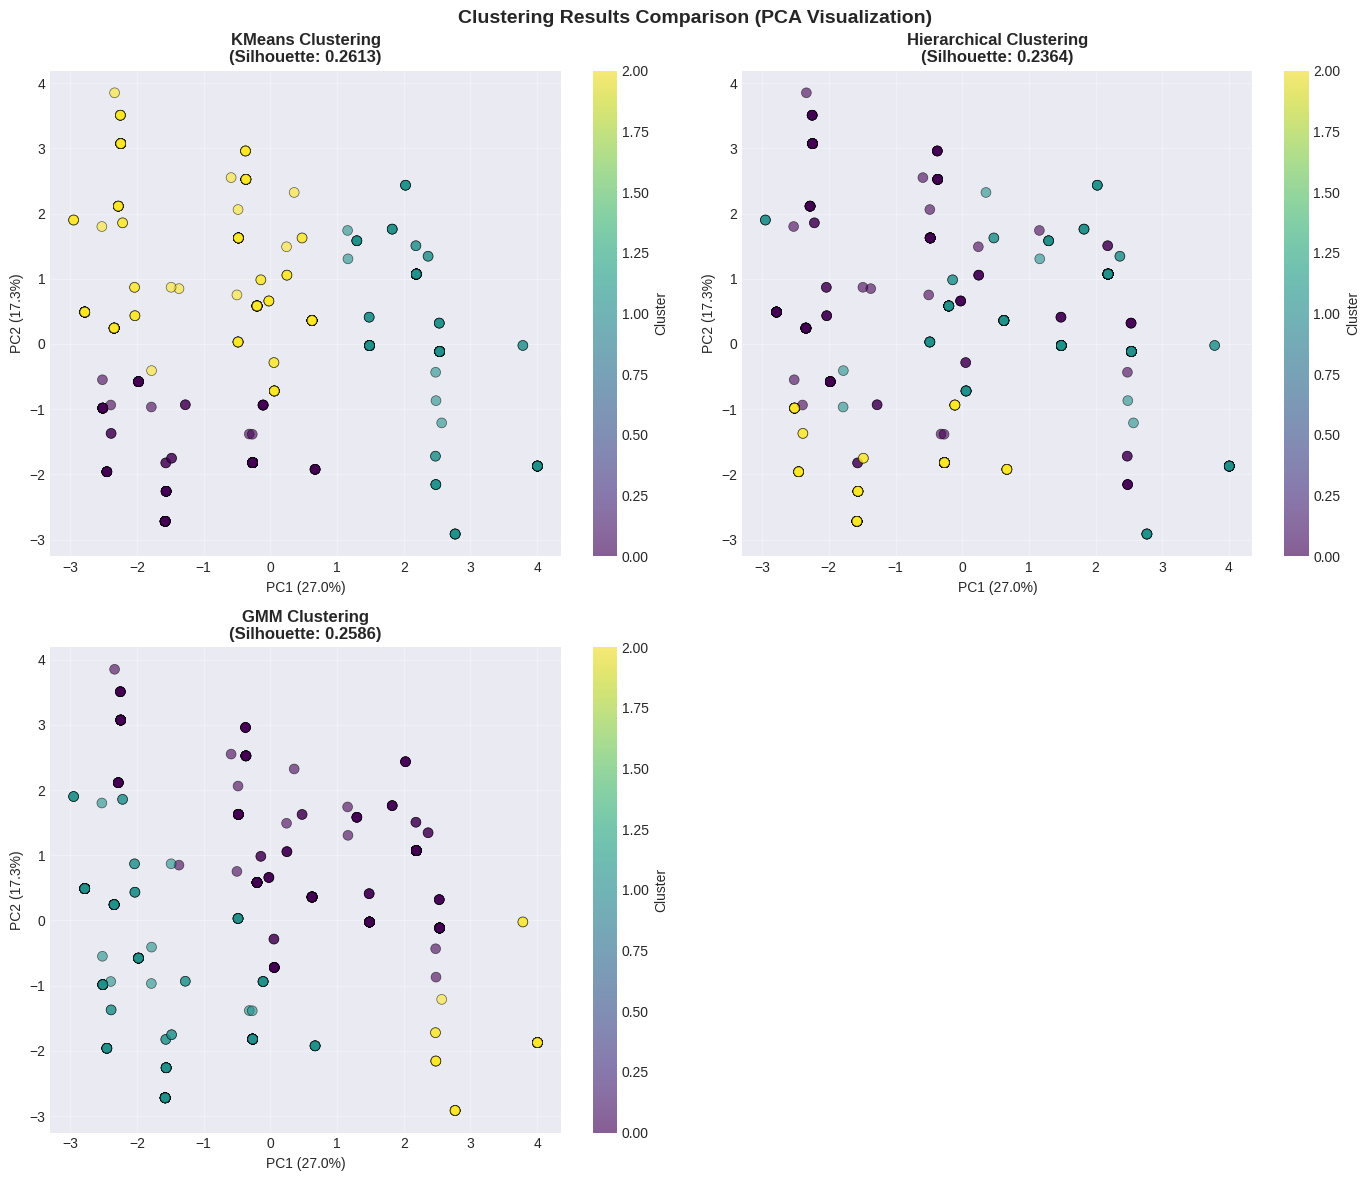

✓ Saved: 06_clustering_comparison.png


In [27]:
print("\n[3] Visualizing Clustering Results")

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Clustering Results Comparison (PCA Visualization)', fontsize=14, fontweight='bold')

algorithms = ['KMeans', 'Hierarchical', 'GMM']
plot_idx = 0

for algo in algorithms:
    if algo in results and plot_idx < 4:
        ax = axes[plot_idx // 2, plot_idx % 2]
        labels = results[algo]['labels']
        
        scatter = ax.scatter(df_pca[:, 0], df_pca[:, 1], c=labels, cmap='viridis',
                           alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
        ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
        ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
        ax.set_title(f'{algo} Clustering\n(Silhouette: {results[algo]["silhouette"]:.4f})',
                    fontweight='bold')
        ax.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax, label='Cluster')
        plot_idx += 1

if plot_idx < 4:
    fig.delaxes(axes[1, 1])

plt.tight_layout()
plt.savefig('06_clustering_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: 06_clustering_comparison.png")

# PHASE 4: CLUSTER PROFILING & INTERPRETATION

## 4.1 Cluster Profiling

In [29]:
print("\n" + "="*80)
print("PHASE 4: CLUSTER ANALYSIS & INTERPRETATION")
print("="*80)

print("\n[1] Cluster Profiling (K-Means)")
print("-"*80)

# best_labels should come from KMeans run on df_scaled (which preserves index)
best_labels = results['KMeans']['labels']  # array-like, length == len(df_scaled)

# Create a Series with the same index as df_scaled / df_num
labels_series = pd.Series(best_labels, index=df_scaled.index, name="Cluster")

# Start from original prepared data and join on index
df_clustered = df_prep.copy()
df_clustered = df_clustered.join(labels_series)  # rows not clustered get NaN Cluster

print("\nCluster Distribution (non-null clusters only):")
cluster_counts = df_clustered['Cluster'].dropna().value_counts().sort_index()
display(cluster_counts)

print("\nCluster Proportions (relative to all rows in df_clustered):")
cluster_props = (cluster_counts / len(df_clustered) * 100).sort_index()
for cluster_id, prop in cluster_props.items():
    print(f"  Cluster {int(cluster_id)}: {prop:.1f}%")



PHASE 4: CLUSTER ANALYSIS & INTERPRETATION

[1] Cluster Profiling (K-Means)
--------------------------------------------------------------------------------

Cluster Distribution (non-null clusters only):


Cluster
0.00    189
1.00    228
2.00    261
Name: count, dtype: int64


Cluster Proportions (relative to all rows in df_clustered):
  Cluster 0: 23.6%
  Cluster 1: 28.5%
  Cluster 2: 32.6%


## 4.2 Detailed Cluster Profiles

In [31]:
print("\n" + "-"*80)
print("DETAILED CLUSTER PROFILES")
print("-"*80)

cluster_profiles = {}
numerical_cols_for_profiling = df_prep.select_dtypes(include=[np.number]).columns.tolist()

for cluster_id in sorted(df_clustered['Cluster'].dropna().unique()):
    print(f"\n{'='*80}")
    print(f"CLUSTER {int(cluster_id)}")
    print(f"{'='*80}")
    
    cluster_data = df_clustered[df_clustered['Cluster'] == cluster_id]
    cluster_size = len(cluster_data)
    cluster_pct = cluster_size / len(df_clustered) * 100
    
    print(f"\nSize: {cluster_size} employees ({cluster_pct:.1f}%)")
    
    profile = {
        'size': cluster_size,
        'percentage': cluster_pct,
        'statistics': {}
    }
    
    key_vars = [
        'Absenteeism time in hours', 'Age', 'Distance from Residence to Work',
        'Estimated commute time', 'Service time', 'Body mass index',
        'Commute_Burden_Index'
    ]
    
    print(f"\nKey Characteristics:")
    for col in key_vars:
        if col in cluster_data.columns:
            # Force numeric, turn non-numeric (e.g. '-') into NaN
            cluster_col = pd.to_numeric(cluster_data[col], errors='coerce')
            overall_col = pd.to_numeric(df_prep[col], errors='coerce')
            
            mean_val = cluster_col.mean()
            overall_mean = overall_col.mean()
            std_val = cluster_col.std()
            diff = mean_val - overall_mean
            pct_diff = (diff / overall_mean * 100) if overall_mean != 0 else 0
            
            profile['statistics'][col] = {
                'mean': mean_val,
                'std': std_val,
                'diff': diff,
                'pct_diff': pct_diff
            }
            
            print(
                f"  {col:40s}: {mean_val:8.2f} "
                f"(overall: {overall_mean:8.2f}, Δ: {diff:+7.2f}, {pct_diff:+6.1f}%)"
            )
    
    cluster_profiles[cluster_id] = profile



--------------------------------------------------------------------------------
DETAILED CLUSTER PROFILES
--------------------------------------------------------------------------------

CLUSTER 0

Size: 189 employees (23.6%)

Key Characteristics:
  Absenteeism time in hours               :     8.80 (overall:     7.09, Δ:   +1.71,  +24.1%)
  Age                                     :    33.94 (overall:    34.40, Δ:   -0.46,   -1.3%)
  Distance from Residence to Work         :    29.55 (overall:    29.80, Δ:   -0.25,   -0.8%)
  Estimated commute time                  :    58.49 (overall:    59.35, Δ:   -0.86,   -1.4%)
  Service time                            :    12.18 (overall:    12.51, Δ:   -0.32,   -2.6%)
  Body mass index                         :    26.30 (overall:    26.64, Δ:   -0.34,   -1.3%)
  Commute_Burden_Index                    :     0.55 (overall:     0.55, Δ:   -0.00,   -0.5%)

CLUSTER 1

Size: 228 employees (28.5%)

Key Characteristics:
  Absenteeism time in hours  

# PHASE 5: ACTIONABLE INSIGHTS & HR STRATEGIES

## 5.1 Feature Importance


PHASE 5: ACTIONABLE INSIGHTS & HR STRATEGIES

[1] Feature Importance Analysis
--------------------------------------------------------------------------------

Top 15 Most Important Features:


,Feature,Importance
14,Commute_Burden_Index,0.17
2,Distance from Residence to Work,0.16
4,Years until retirement,0.15
3,Estimated commute time,0.15
6,Education,0.09
8,Social drinker,0.07
13,Age,0.07
1,Transportation expense,0.06
12,Body mass index,0.04
10,Number of pets,0.02


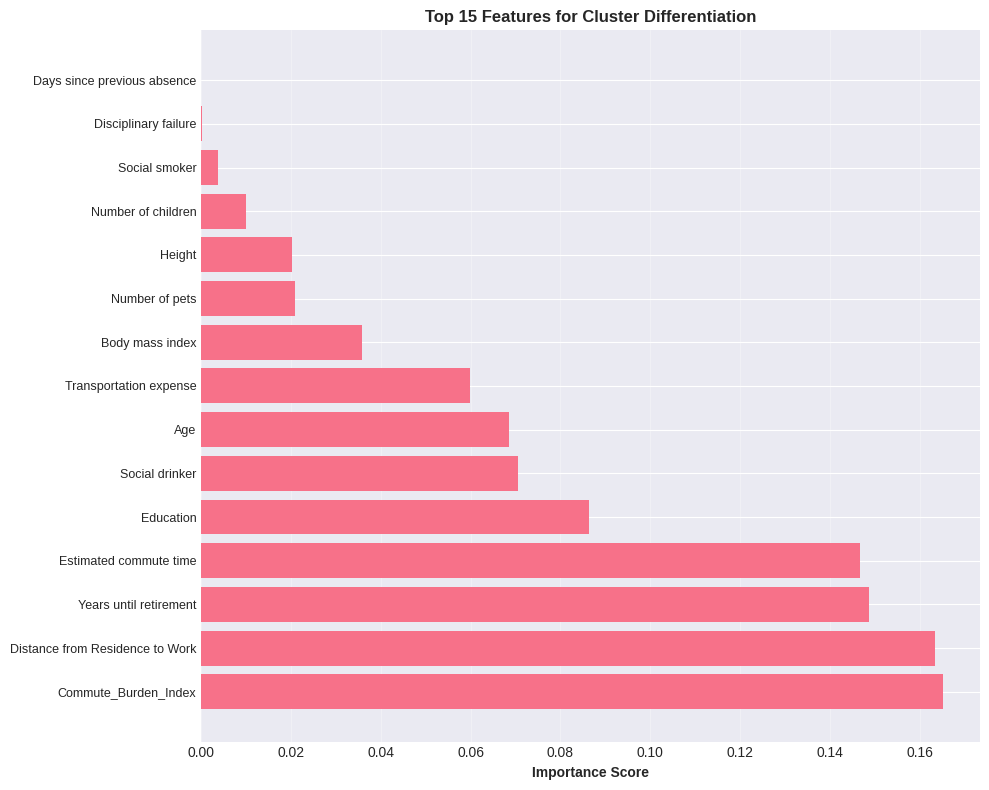


✓ Saved: 07_feature_importance.png


In [32]:
print("\n" + "="*80)
print("PHASE 5: ACTIONABLE INSIGHTS & HR STRATEGIES")
print("="*80)

print("\n[1] Feature Importance Analysis")
print("-"*80)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(df_scaled, best_labels)

feature_importance = pd.DataFrame({
    'Feature': df_scaled.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 15 Most Important Features:")
display(feature_importance.head(15))

fig, ax = plt.subplots(figsize=(10, 8))
top_features = feature_importance.head(15)
ax.barh(range(len(top_features)), top_features['Importance'].values)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'].values, fontsize=9)
ax.set_xlabel('Importance Score', fontweight='bold')
ax.set_title('Top 15 Features for Cluster Differentiation', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('07_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Saved: 07_feature_importance.png")

## 5.2 HR Strategies for Each Cluster

In [33]:
print("\n[2] Cluster-Specific HR Strategies")
print("-"*80)

strategies = {}

for cluster_id, profile in cluster_profiles.items():
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster_id}: HR INTERVENTION STRATEGY")
    print(f"{'='*80}")
    print(f"Size: {profile['size']} employees ({profile['percentage']:.1f}%)\n")
    
    stats = profile['statistics']
    
    avg_absence = stats.get('Absenteeism time in hours', {}).get('mean', 0)
    age = stats.get('Age', {}).get('mean', 0)
    distance = stats.get('Distance from Residence to Work', {}).get('mean', 0)
    bmi = stats.get('Body mass index', {}).get('mean', 0)
    
    recommendations = []
    
    if avg_absence > 5:
        print(f"⚠️  HIGH ABSENCE RISK: Average {avg_absence:.1f} hours/absence")
        recommendations.extend([
            "• Implement comprehensive wellness program",
            "• Schedule regular manager check-ins (bi-weekly)",
            "• Investigate root causes (health, burnout, engagement)",
            "• Consider flexible work arrangements",
            "• Provide mental health and counseling support"
        ])
    elif avg_absence < 2:
        print(f"✓ LOW ABSENCE: Average {avg_absence:.1f} hours/absence")
        recommendations.extend([
            "• Recognize and reward strong attendance",
            "• Use as model for culture development",
            "• Leadership development opportunities",
            "• Career advancement pathways"
        ])
    else:
        print(f"~ MODERATE ABSENCE: Average {avg_absence:.1f} hours/absence")
        recommendations.extend([
            "• Monitor quarterly",
            "• Maintain current support levels",
            "• Career development opportunities"
        ])
    
    if distance > 20:
        print(f"🚗 LONG COMMUTE: {distance:.1f} km average")
        recommendations.extend([
            "• Offer flexible work schedule",
            "• Remote work options (2-3 days/week)",
            "• Commute support programs"
        ])
    
    if bmi > 28:
        print(f"💪 HEALTH FOCUS NEEDED: Average BMI {bmi:.1f}")
        recommendations.extend([
            "• Wellness program with fitness incentives",
            "• Health screening and preventive care"
        ])
    
    print("\nRecommended Actions:")
    for rec in recommendations:
        print(f"  {rec}")
    
    strategies[cluster_id] = recommendations


[2] Cluster-Specific HR Strategies
--------------------------------------------------------------------------------

CLUSTER 0.0: HR INTERVENTION STRATEGY
Size: 189 employees (23.6%)

⚠️  HIGH ABSENCE RISK: Average 8.8 hours/absence
🚗 LONG COMMUTE: 29.6 km average

Recommended Actions:
  • Implement comprehensive wellness program
  • Schedule regular manager check-ins (bi-weekly)
  • Investigate root causes (health, burnout, engagement)
  • Consider flexible work arrangements
  • Provide mental health and counseling support
  • Offer flexible work schedule
  • Remote work options (2-3 days/week)
  • Commute support programs

CLUSTER 1.0: HR INTERVENTION STRATEGY
Size: 228 employees (28.5%)

⚠️  HIGH ABSENCE RISK: Average 5.5 hours/absence
🚗 LONG COMMUTE: 31.5 km average

Recommended Actions:
  • Implement comprehensive wellness program
  • Schedule regular manager check-ins (bi-weekly)
  • Investigate root causes (health, burnout, engagement)
  • Consider flexible work arrangements
  

## 5.3 Risk Scoring System


[3] Employee Absence Risk Scoring
--------------------------------------------------------------------------------

Top 20 At-Risk Employees (by Risk Score, unique profiles):


,Risk_Score,Cluster,Age,Distance from Residence to Work,Body mass index
0,87.39,1.00,26,52,27
1,83.75,1.00,36,51,31
2,78.49,2.00,47,48,36
3,76.52,0.00,29,51,21
4,73.12,2.00,30,50,23
5,72.51,0.00,34,50,23
6,70.94,NaN,34,49,21
7,66.96,NaN,51,45,25
8,62.98,2.00,37,35,35
9,61.65,1.00,25,42,21


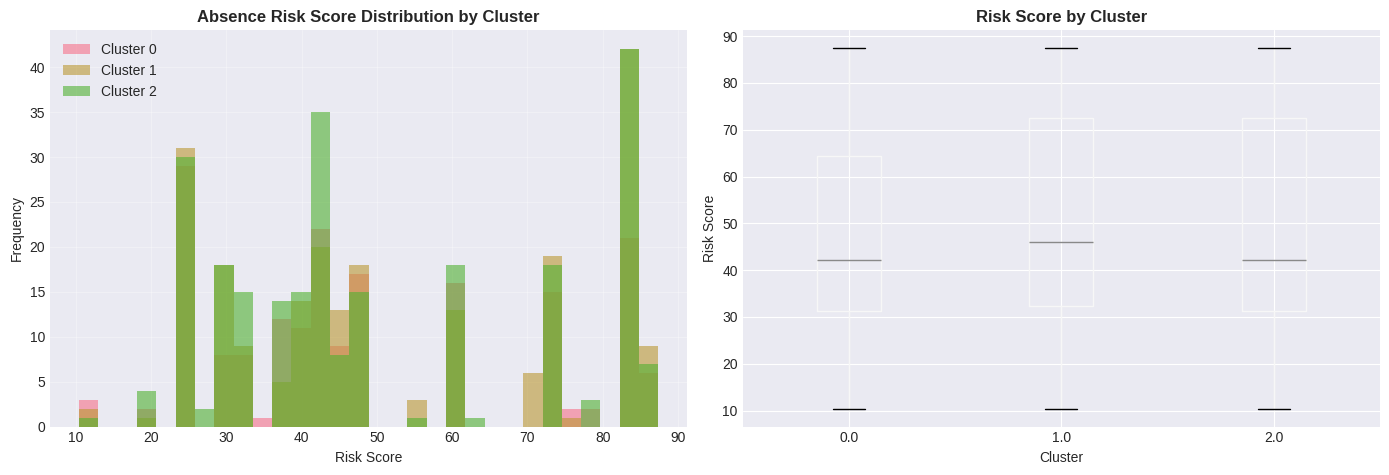


✓ Saved: 08_risk_scoring.png

Average Risk Score by Cluster:
         mean   std   min   max
Cluster                        
0.00    48.90 21.00 10.44 87.39
1.00    52.64 22.41 10.44 87.39
2.00    50.36 21.73 10.44 87.39


In [38]:
print("\n[3] Employee Absence Risk Scoring")
print("-" * 80)

df_risk = df_prep.copy()

# 1) Ensure numeric types for risk components
cols_for_risk = [
    'Distance from Residence to Work',
    'Estimated commute time',
    'Body mass index',
    'Service time'
]

for col in cols_for_risk:
    df_risk[col] = pd.to_numeric(df_risk[col], errors='coerce')

# 2) Drop rows with missing values in risk components (safest)
df_risk = df_risk.dropna(subset=cols_for_risk)

# 3) Min-max normalization for distance, commute, BMI
distance_norm = (
    df_risk['Distance from Residence to Work'] - df_risk['Distance from Residence to Work'].min()
) / (
    df_risk['Distance from Residence to Work'].max() - df_risk['Distance from Residence to Work'].min()
)

commute_norm = (
    df_risk['Estimated commute time'] - df_risk['Estimated commute time'].min()
) / (
    df_risk['Estimated commute time'].max() - df_risk['Estimated commute time'].min()
)

bmi_norm = (
    df_risk['Body mass index'] - df_risk['Body mass index'].min()
) / (
    df_risk['Body mass index'].max() - df_risk['Body mass index'].min()
)

# 4) Higher service time = lower risk
service_component = 1 - df_risk['Service time'] / df_risk['Service time'].max()

# 5) Final risk score
df_risk['Risk_Score'] = (
    distance_norm * 0.35 +
    commute_norm * 0.35 +
    bmi_norm * 0.20 +
    service_component * 0.10
) * 100

# 6) Align clusters with df_risk index
df_risk['Cluster'] = df_clustered.loc[df_risk.index, 'Cluster']

print("\nTop 20 At-Risk Employees (by Risk Score, unique profiles):")
top_risk = (
    df_risk[['Risk_Score', 'Cluster', 'Age',
             'Distance from Residence to Work', 'Body mass index']]
    .sort_values('Risk_Score', ascending=False)
    .drop_duplicates(subset=['Age', 'Distance from Residence to Work', 'Body mass index'])
    .head(20)
)
display(top_risk.reset_index(drop=True))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 7) Histogram by cluster
for cluster_id in sorted(df_risk['Cluster'].dropna().unique()):
    cluster_data = df_risk[df_risk['Cluster'] == cluster_id]
    axes[0].hist(
        cluster_data['Risk_Score'],
        bins=30,
        alpha=0.6,
        label=f'Cluster {int(cluster_id)}'
    )

axes[0].set_title('Absence Risk Score Distribution by Cluster', fontweight='bold')
axes[0].set_xlabel('Risk Score')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 8) Boxplot by cluster
df_risk.boxplot(column='Risk_Score', by='Cluster', ax=axes[1])
axes[1].set_title('Risk Score by Cluster', fontweight='bold')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Risk Score')
plt.suptitle('')

plt.tight_layout()
plt.savefig('08_risk_scoring.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Saved: 08_risk_scoring.png")

print("\nAverage Risk Score by Cluster:")
print(df_risk.groupby('Cluster')['Risk_Score'].agg(['mean', 'std', 'min', 'max']))


## 5.4 Export Results

In [39]:
print("\n" + "█"*80)
print("█" + " "*78 + "█")
print("█" + " "*25 + "ANALYSIS COMPLETE!" + " "*32 + "█")
print("█" + " "*78 + "█")
print("█"*80)

df_clustered.to_csv('employees_with_clusters.csv', index=False)
df_risk.to_csv('employees_with_risk_scores.csv', index=False)

print("\n✓ All visualizations saved as PNG files:")
print("  - 01_target_distribution.png")
print("  - 02_correlation_matrix.png")
print("  - 03_categorical_analysis.png")
print("  - 04_preprocessing_impact.png")
print("  - 05_optimal_clusters_validation.png")
print("  - 06_clustering_comparison.png")
print("  - 07_feature_importance.png")
print("  - 08_risk_scoring.png")

print("\n✓ Data files exported:")
print("  - employees_with_clusters.csv")
print("  - employees_with_risk_scores.csv")

print("\n✓ Clustering complete with 3 distinct employee segments")
print("✓ HR strategies developed for each cluster")
print("✓ Risk scoring system implemented")

print("\nNEXT STEPS:")
print("  1. Review all visualizations and outputs")
print("  2. Write comprehensive report with findings")
print("  3. Present insights to HR leadership")
print("  4. Begin pilot interventions with Cluster 0")

print("\n" + "█"*80)

# PART 2: CLUSTERING & PROFILING
# Continue from Part 1...


████████████████████████████████████████████████████████████████████████████████
█                                                                              █
█                         ANALYSIS COMPLETE!                                █
█                                                                              █
████████████████████████████████████████████████████████████████████████████████

✓ All visualizations saved as PNG files:
  - 01_target_distribution.png
  - 02_correlation_matrix.png
  - 03_categorical_analysis.png
  - 04_preprocessing_impact.png
  - 05_optimal_clusters_validation.png
  - 06_clustering_comparison.png
  - 07_feature_importance.png
  - 08_risk_scoring.png

✓ Data files exported:
  - employees_with_clusters.csv
  - employees_with_risk_scores.csv

✓ Clustering complete with 3 distinct employee segments
✓ HR strategies developed for each cluster
✓ Risk scoring system implemented

NEXT STEPS:
  1. Review all visualizations and outputs
  2. Write comprehensiv